In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import progressbar
!rm -d -f -r rm *.zip
!rm -rf images
!rm -rf visualized


!wget -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/joints.mat
joints=scipy.io.loadmat('joints.mat')['joints']
# poses = joints [0:2 , : , :]
poses = joints

!wget  -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/images.zip
!unzip -q  /content/images.zip

images_directory=os.listdir('/content/images')
target_size=(220,220)
resized_images=[]
resized_poses=[]
original_scale=[]
originalImages = []
# datasetDictionary = {}
for idx,x in progressbar.progressbar(enumerate(images_directory)):
    path=os.path.join('/content/images',x)
    
    image = plt.imread(path)
    height,width=image.shape[0],image.shape[1]
    # print(height)
    # print(width)
    scale_w,scale_h=220/width,220/height
    original_scale.append([width,height])
    # originalImages.appned(image)
    resized_poses.append([poses[0,:,idx]*scale_w*2-1,poses[1,:,idx]*scale_h*2-1])
    
    image=cv2.resize(image,target_size,interpolation=cv2.INTER_AREA)
    resized_images.append(image)


    
resized_images=np.array(resized_images)


print(resized_images.shape)
resized_poses=np.array(resized_poses)
print(resized_poses.shape)
original_scale=np.array(original_scale)

print(original_scale.shape)


np.save('Leeds Sports Dataset NPY.npy',resized_images[:1600])
np.save('Resized Poses.npy',resized_poses[:1600])
np.save('Image scale.npy',original_scale[:1600])
np.save('Leeds Sports Dataset NPY Test.npy',resized_images[1600:])
np.save('Resized Poses Test.npy',resized_poses[1600:])
np.save('Image scale Test.npy',original_scale[1600:])

File ‘joints.mat’ already there; not retrieving.

--2021-12-13 05:43:39--  https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/images.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/images.zip [following]
--2021-12-13 05:43:40--  https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10319538 (9.8M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   9.84M  --.-KB/s    in 0.1s    

2021-12-13 05:43:40 (95.4 MB/s) 

| |                      #                         | 1999 Elapsed Time: 0:00:02


(2000, 220, 220, 3)
(2000, 2, 14)
(2000, 2)


In [43]:
x_train = resized_images[:1600]
y_train = resized_poses[:1600]
train_reconstruction_coefficient = original_scale[:1600]


x_test = resized_images[1600:]
y_test = resized_poses[1600:]
test_reconstruction_coefficient  =original_scale[1600:]

In [44]:
# def define_model(self):
#   #Changes made on model architecture
#   #LRN->BN, Pooling->Strided Convolution
#   model=tf.keras.models.Sequential()
#   model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
#   model.add(tf.keras.layers.BatchNormalization())
#   model.add(tf.keras.layers.ReLU())
#   model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
#   model.add(tf.keras.layers.BatchNormalization())
#   model.add(tf.keras.layers.ReLU())
#   model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
#   model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
#   model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
#   model.add(tf.keras.layers.MaxPooling2D())
#   model.add(tf.keras.layers.Flatten())
#   model.add(tf.keras.layers.Dense(4096,activation='relu'))
#   model.add(tf.keras.layers.Dropout(0.4))
#   model.add(tf.keras.layers.Dense(4096,activation='relu'))
#   model.add(tf.keras.layers.Dropout(0.4))
#   model.add(tf.keras.layers.Dense(28,activation='linear'))
#   return model

In [51]:
y_test.shape

(400, 2, 14)

In [53]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import cv2
import scipy
import progressbar
class DatasetManager():
  def __init__(self,dataset_name):
    self.data=self.load_dataset('lsp')
    # print(len(self.data))
    # return self.data
  def load_dataset(self,name):
    if name=='lsp':
      df=dict()
      df['images']=x_train
      df['poses']=self.to_relative_coord(y_train,220)
      #df['scale']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Image scale.npy')

      df['test images']=x_test
      df['test poses']=self.to_relative_coord(y_test,220)
      #df['test scale']=np.load('/content/drive/My Drive/data/Pose Estimation/LSP-Extended/Image scale Test.npy')
      # print(len(df))
      return df

  def compare_pose(self,index,model,test):
    #Compare ground truth vs predicted pose
    if test:
      predicted_pose=self.to_absolute_coord(model.model.predict(self.data['test images'][index:index+1]),220)
    else:
      predicted_pose=self.to_absolute_coord(model.model.predict(self.data['images'][index:index+1]),220)
    pose_width,pose_height=predicted_pose[0][:14],predicted_pose[0][14:]
    plt.figure(figsize=(10,10))
    if test:
      plt.imshow(self.data['test images'][index])
    else:
      plt.imshow(self.data['images'][index])
    plt.scatter(pose_width,pose_height,c='g',label='Predicted')
    if test:
      plt.scatter(self.to_absolute_coord(dataset.data['test poses'][index][0],220),self.to_absolute_coord(dataset.data['test poses'][index][1],220),c='r',label='True')
    else:
      print(self.to_absolute_coord(dataset.data['poses'][index][0],220))
      plt.scatter(self.to_absolute_coord(dataset.data['poses'][index][0],220),self.to_absolute_coord(dataset.data['poses'][index][1],220),c='r',label='True')
    plt.legend()
    plt.show()

  def augment_images(self):
    new_images=[]
    new_poses=[]
    for idx in progressbar.progressbar(range(self.data['poses'].shape[0])):
      x,y=self.data['poses'][idx][0],self.data['poses'][idx][1]
      image=self.data['images'][idx]
      #Flip image at 50%
      if np.random.randint(2)==1:
        image=np.fliplr(image)
        x=-x
      if np.random.randint(2)==1:
        image=np.flipud(image)
        y=-y

      #transform image
      #transformation_scale=np.array([np.random.rand()*2-1,np.random.rand()*2-1,0])*0.4
      #image=scipy.ndimage.shift(image,(transformation_scale*220).astype(int),mode='nearest')
      x+=transformation_scale[0]*2
      y+=transformation_scale[1]*2

      new_images.append(image)
      new_poses.append(np.array([x,y]))

    return np.array(new_images),np.array(new_poses)
  def test_pdj(self,model,joint_index):
    joint_index=['Right elbow','Right wrist']
    name2index={'Right ankle':0,
    'Right knee':1,
    'Right hip':2,
    'Left hip':3,
    'Left knee':4,
    'Left ankle':5,
    'Right wrist':6,
    'Right elbow':7,
    'Right shoulder':8,
    'Left shoulder':9,
    'Left elbow':10,
    'Left wrist':11,
    'Neck':12,
    'Head top':13}
    min_d,max_d=0,1
    pred=model.model.predict(self.data['test images'])
    true=self.data['test poses']

    pred_x,pred_y=pred[:,:14],pred[:,14:]
    true_x,true_y=true[:,0],true[:,1]

    distance=np.sqrt((pred_x-true_x)**2+(pred_y-true_y)**2)
    arr=[[]for _ in joint_index]
    for x in np.arange(min_d,max_d,0.001):
      for idx,joint in enumerate(joint_index):
        arr[idx].append(np.sum(distance<x,axis=0)[name2index[joint]]/pred.shape[0])
    for idx,joint in enumerate(joint_index):
      plt.plot(np.arange(min_d,max_d,0.001),arr[idx],label=joint)
    plt.legend()
    plt.show()
  def to_relative_coord(self,coord,size):
    return coord/size*2-1

  def to_absolute_coord(self,coord,size):
    return (coord+1)/2*size
    
class DeepPoseModel():
  def __init__(self,dataset,training_config):
    self.dataset=dataset
    self.training_config=training_config

    self.model=self.define_model()
    self.cascade_1=self.define_model(final_op=2)

    self.model.compile(optimizer=tf.keras.optimizers.Adam(training_config['Learning Rate']),loss=tf.keras.losses.mse)
    self.load_model()

    if training_config['Train model'] == True:
      self.train_model()

  def save_model(self):
    self.checkpoint.save(file_prefix = self.checkpoint_prefix)
 
  def load_model(self):
    checkpoint_dir = '/content/drive/My Drive/logs/DeepPosev1'
    self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    self.checkpoint = tf.train.Checkpoint(model=self.model,cascade=self.cascade_1)
    self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def to_relative_coord(self,coord,size):
    #Change pose scale to [-1, 1] scale
    return coord/size*2-1

  def to_absolute_coord(self,coord,size):
    #Change pose scale to scale on image size
    return (coord+1)/2*size

  def draw_pose(self,image_name):
    #Model draw pose on new image
    img=plt.imread(image_name)

    img_resized=cv2.resize(img,(220,220),interpolation=cv2.INTER_AREA)
    poses=self.model.predict(np.array([img_resized]))[0]
    poses_x,poses_y=poses[:14],poses[14:]
    poses_x=self.to_absolute_coord(poses_x,img.shape[1])
    poses_y=self.to_absolute_coord(poses_y,img.shape[0])

    plt.imshow(img)
    plt.scatter(poses_x,poses_y,c='r')
    plt.show()

  def train_model(self):
    
    #Concatenate [ [X_coord], [Y_coord] ] -> [ Xcoord, Y_coord ]
    y_data=np.concatenate((self.dataset.data['poses'][:,0],self.dataset.data['poses'][:,1]),axis=1)
    y_val=np.concatenate((self.dataset.data['test poses'][:,0],self.dataset.data['test poses'][:,1]),axis=1)
    val_dataset = tf.data.Dataset.from_tensor_slices((self.dataset.data['test images'], y_val))
    val_dataset = val_dataset.batch(64)
    
    loss,val_loss=[],[]
    for epoch in range(self.training_config['Epochs']):
      print('Epoch',epoch+1)
      training_history=self.model.fit(x=self.dataset.data['images'],y=y_data,epochs=1,batch_size=128,validation_data=val_dataset,verbose=2)
      loss.append(training_history.history['loss'])
      val_loss.append(training_history.history['val_loss'])
      #dataset.draw_pose(0,self)
      if (epoch+1)%10==0:
        self.save_model()
    self.training_log={'loss':loss,'val_loss':val_loss}
  def define_model(self,final_op=28):
    #Changes made on model architecture
    #LRN->BN, Pooling->Strided Convolution
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(final_op,activation='linear'))
    return model

In [54]:
# with tf.device('/device:GPU:0'):
dataset=DatasetManager('lsp')

DeepPose=DeepPoseModel(dsm,{'Train model':False,'Learning Rate':0.0005,'Epochs':100})

In [55]:
dataset.data['test images']


array([[[[119, 108, 102],
         [119, 108, 102],
         [123, 111, 105],
         ...,
         [142, 153, 175],
         [141, 152, 174],
         [141, 152, 174]],

        [[124, 113, 107],
         [124, 113, 107],
         [126, 114, 108],
         ...,
         [141, 152, 174],
         [141, 152, 174],
         [141, 152, 174]],

        [[108,  98,  92],
         [108,  98,  92],
         [109,  98,  91],
         ...,
         [141, 152, 174],
         [140, 151, 173],
         [140, 151, 173]],

        ...,

        [[135, 109, 102],
         [135, 109, 102],
         [138, 112, 104],
         ...,
         [160, 145, 141],
         [162, 147, 143],
         [162, 147, 143]],

        [[132, 105,  98],
         [132, 105,  98],
         [137, 110, 103],
         ...,
         [165, 150, 145],
         [168, 153, 148],
         [168, 153, 148]],

        [[132, 105,  98],
         [132, 105,  98],
         [137, 110, 103],
         ...,
         [175, 160, 155],
        

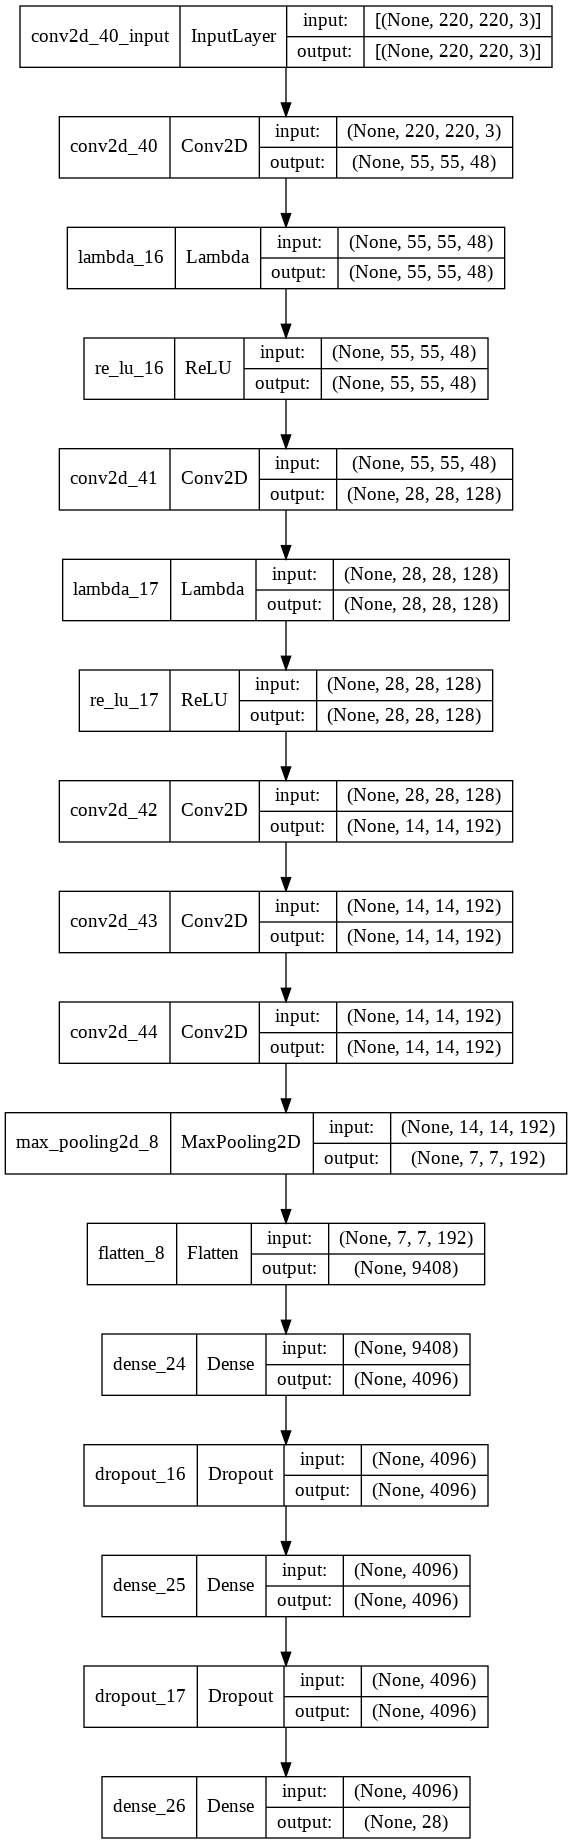

In [56]:
tf.keras.utils.plot_model(DeepPose.model,show_shapes=True)

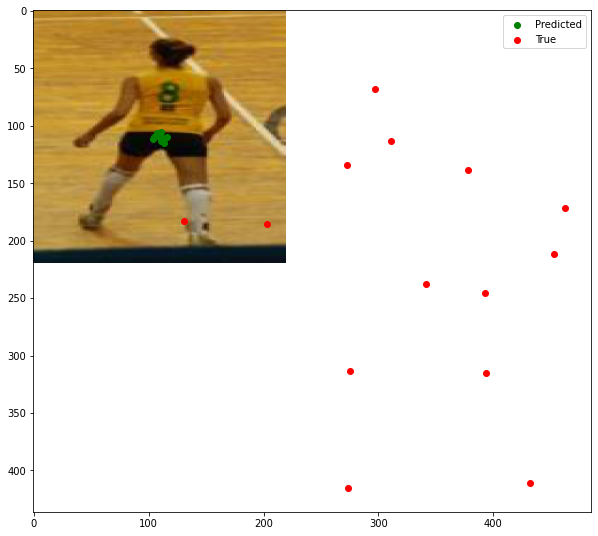

[160.11569707  46.02380146 135.50764115 127.67780518  24.77138953
 136.62618915 421.85592819 346.91321244 277.56323668 314.47532055
 377.11400834 456.53091608 330.1349925  379.35110434]


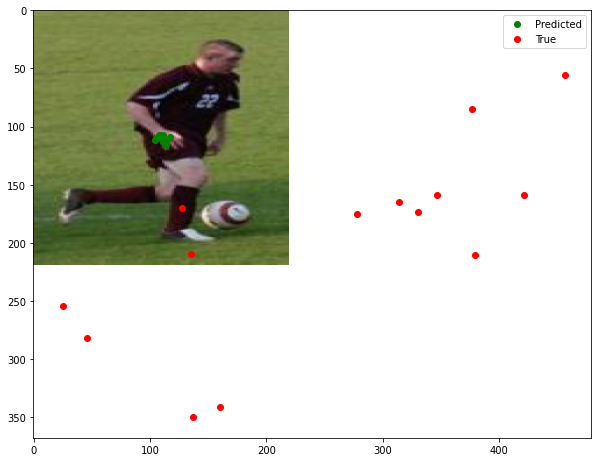

In [57]:
dataset.compare_pose(10,DeepPose,True)
dataset.compare_pose(100,DeepPose,False)

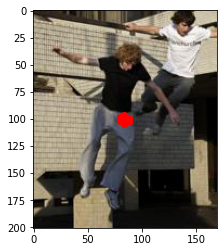

In [40]:
DeepPose.draw_pose('images/im0008.jpg')


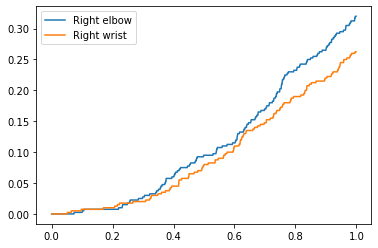

In [41]:
dataset.test_pdj(DeepPose,['Right wrist','Right elbow'])

In [21]:
plt.plot(DeepPose.training_log['loss'],label='Training Loss')
plt.plot(DeepPose.training_log['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

AttributeError: ignored

In [22]:
image,joints=dataset.augment_images()
joints.shape

N/A% (0 of 1600) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

NameError: ignored

In [ ]:
dataset.data['poses'].shape